In [1]:
from coatiLDM.constants import FLOW_MODELS, DIFFUSION_MODELS, CLASSIFIER_GUIDE_DOCS, COATI2_DOCS, DFLOW_CLASSIFIER_DOCS
from coatiLDM.models.io import load_score_model_from_model_doc, load_flow_model_from_model_doc, load_due_cg_from_model_doc
from coatiLDM.common.utils import uniform_sample_in_range
import torch
from coatiLDM.models.diffusion_models import ddpm_sample_routines
from coatiLDM.data.transforms import safe_embed_scalar
from coatiLDM.models.coati.io import load_coati2
from coatiLDM.data.decoding import force_decode_valid_batch_efficient
from coatiLDM.models.score_models.flow_wrapper import ODEWrapper
from coatiLDM.models.score_models.due_dflow import load_inference_due_for_dflow
from rdkit import Chem
# import crippen logp
from rdkit.Chem.Crippen import MolLogP
import numpy as np
from rdkit.Chem import Draw

from coatiLDM.models.diffusion_models.dflow import dflow

In [2]:
# set a device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
coati, tokenizer = load_coati2(
    COATI2_DOCS["general_doc"],
    DEVICE,
    freeze=True,
    old_architecture=False,
    force_cpu=False,  # needed to deserialize on some cpu-only machines
)

Loading model from s3://terray-public/coatiLDM/models/general_doc.pt


File downloaded successfully to /home/benk/coatiLDM/models/general_doc.pt
Loading tokenizer coati2_12_12 from s3://terray-public/coatiLDM/models/general_doc.pt
number of parameters: 50.44M
number of parameters Total: xformer: 54.81M 
vocab_name not found in tokenizer_vocabs, trying to load from file
Freezing encoder
56385536 params frozen!


we'll demo LogP generations for each model type

In [4]:
# some setup + utility functions
def get_logp_targets(n_samples,logp_cdf,dim_per_cond):
    logp_targets = torch.tensor(uniform_sample_in_range(n_samples,0,1))
    invcdf_logp = logp_cdf.invcdf(logp_targets)
    embed_logp = safe_embed_scalar(logp_targets, dim_per_cond).to(DEVICE)
    return logp_targets, invcdf_logp, embed_logp

def smiles_to_grid_with_logp(smiles_list, mol_logp_list, target_logp_list, n):
    molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list[:n]]
    labels = [f"Mol LogP: {mol_logp:.2f}\nTarget LogP: {target_logp:.2f}" 
              for mol_logp, target_logp in zip(mol_logp_list[:n], target_logp_list[:n])]
    
    img = Draw.MolsToGridImage(molecules, molsPerRow=5, legends=labels, subImgSize=(200, 200))
    
    return img
diffusion_model_doc = DIFFUSION_MODELS['logp_diff']
diffusion_model, train_args, cdfs  = load_score_model_from_model_doc(diffusion_model_doc)
cdf_logp= cdfs['logp']

# Conditional Diffusion

In [6]:
diffusion_model = diffusion_model.to(DEVICE)

In [7]:
n_samples = 100
logp_targets, invcdf_logp, embed_logp = get_logp_targets(n_samples,cdf_logp,train_args['dim_per_cond'])

In [8]:
sample_batch = ddpm_sample_routines.ddpm_basic_sample(score_net=diffusion_model,
                                                      cond=embed_logp,
                                                      batch_size=n_samples,
                                                      pg_weight=0.)

In [9]:
smis = force_decode_valid_batch_efficient(sample_batch, coati, tokenizer, 
            max_attempts = 5,
            inv_temp = 1.5, 
            k = 500,
            noise_scale=0., 
            chiral = True,
            silent=False)

24  remaining 
12  remaining 
4  remaining 
2  remaining 
1  remaining 


In [10]:
valid_idxs = [i for i, smi in enumerate(smis) if smi != '']
valid_smis = [smis[i] for i in valid_idxs]
len(valid_idxs)

99

In [11]:
generation_logps = np.asarray([MolLogP(Chem.MolFromSmiles(smi)) for smi in smis if smi != ''])

In [12]:
print(f'conditional diffusion logp correlation: {np.corrcoef(generation_logps, invcdf_logp[valid_idxs])[0,1].item()}')

conditional diffusion logp correlation: 0.8014139277180021


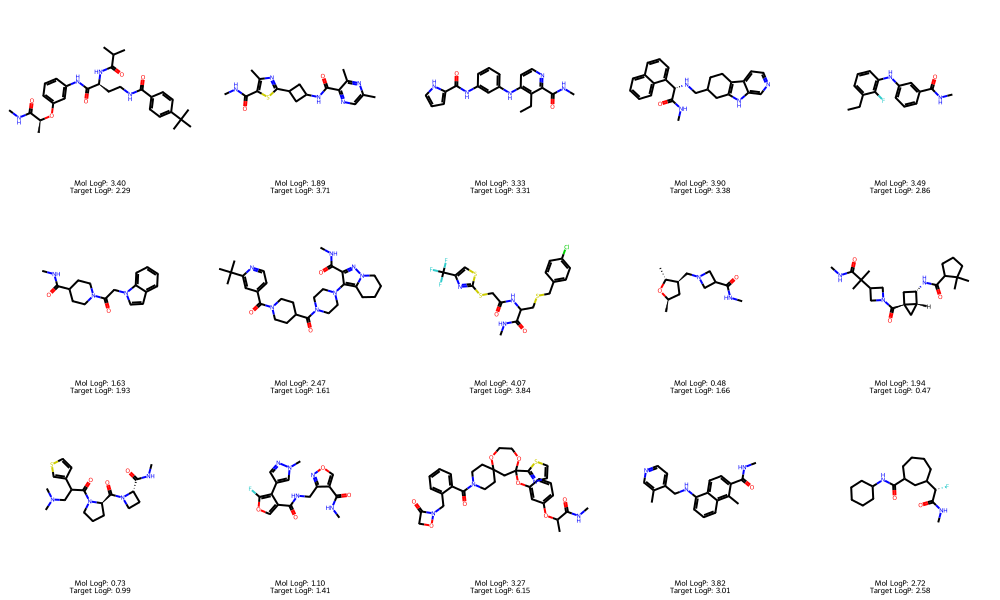

In [14]:
smiles_to_grid_with_logp(valid_smis, generation_logps, invcdf_logp[valid_idxs], 15)

# Classifier Free Guidance

In [5]:
# just need to load the unconditioned model and can reuse the targets from above
diffusion_model_doc = DIFFUSION_MODELS['diffusion_large']
uncond_diffusion_model, train_args_uncond, _  = load_score_model_from_model_doc(diffusion_model_doc)
uncond_diffusion_model = uncond_diffusion_model.eval().to(DEVICE)
#uncond_diffusion_model = torch.load('/home/benk/diffusion_notebooks/diff_direc_linear_weightnorm_big_nobias_1705430883_14002689_ema.pt').score_net


In [7]:
n_samples = 100
logp_targets, invcdf_logp, embed_logp = get_logp_targets(n_samples,cdf_logp,train_args['dim_per_cond'])

In [8]:
embed_logp.shape

torch.Size([100, 32])

In [9]:
sample_batch = ddpm_sample_routines.ddpm_sample_classifier_free_guidance(uncond_score_net=uncond_diffusion_model,
                                                                            cond_score_net=diffusion_model,
                                                                            cond=embed_logp,
                                                                            batch_size=n_samples,
                                                                            pg_weight=0.,
                                                                            cfg_weight=.1)

In [10]:
smis = force_decode_valid_batch_efficient(sample_batch, coati, tokenizer, 
            max_attempts = 5,
            inv_temp = 1.5, 
            k = 500,
            noise_scale=0., 
            chiral = True,
            silent=False)

24  remaining 
11  remaining 
6  remaining 
6  remaining 
5  remaining 


In [11]:
embed_logp.shape

torch.Size([100, 32])

In [12]:
valid_idxs = [i for i, smi in enumerate(smis) if smi != '']
valid_smis = [smis[i] for i in valid_idxs]
len(valid_idxs)

95

In [13]:
generation_logps = np.asarray([MolLogP(Chem.MolFromSmiles(smi)) for smi in smis if smi != ''])

In [18]:
print(f'conditional diffusion logp correlation: {np.corrcoef(generation_logps, invcdf_logp[valid_idxs])[0,1].item()}')

conditional diffusion logp correlation: 0.8401067520429949


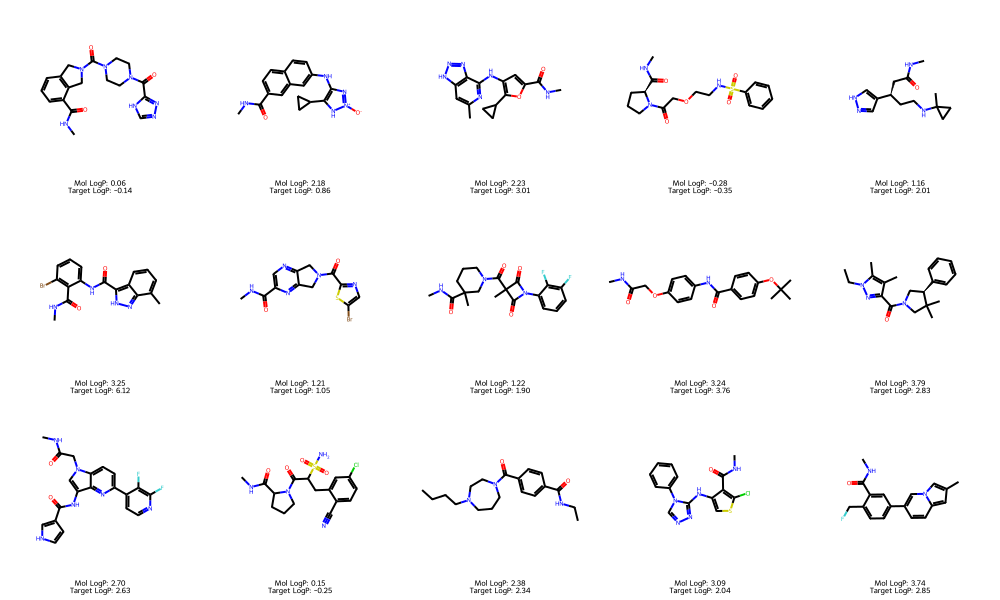

In [17]:
smiles_to_grid_with_logp(valid_smis, generation_logps, invcdf_logp[valid_idxs], 15)

# Classifier Guidance

In [43]:
n_samples = 100
logp_targets, invcdf_logp, embed_logp = get_logp_targets(n_samples,cdf_logp,train_args['dim_per_cond'])

In [6]:
logp_due = load_due_cg_from_model_doc(CLASSIFIER_GUIDE_DOCS['logp']).to(DEVICE)

In [50]:
sample_batch = ddpm_sample_routines.ddpm_sample_multi_classifier_guidance(score_net=uncond_diffusion_model,
                                                                             batch_size=n_samples,
                                                                             cg_weights=[20.],
                                                                             cg_dues=[logp_due],
                                                                             cg_targets=[logp_targets.to(DEVICE)],
                                                                             pg_weight=0.)

In [51]:
smis = force_decode_valid_batch_efficient(sample_batch, coati, tokenizer, 
            max_attempts = 5,
            inv_temp = 1.5, 
            k = 500,
            noise_scale=0., 
            chiral = True,
            silent=False)

31  remaining 
14  remaining 
8  remaining 
6  remaining 
2  remaining 


In [53]:
valid_idxs = [i for i, smi in enumerate(smis) if smi != '']
valid_smis = [smis[i] for i in valid_idxs]
len(valid_idxs)

98

In [54]:
generation_logps = np.asarray([MolLogP(Chem.MolFromSmiles(smi)) for smi in smis if smi != ''])

In [56]:
print(f'Classifier Guidance logp correlation: {np.corrcoef(generation_logps, invcdf_logp[valid_idxs])[0,1].item()}')

Classifier Guidance logp correlation: 0.780046207293694


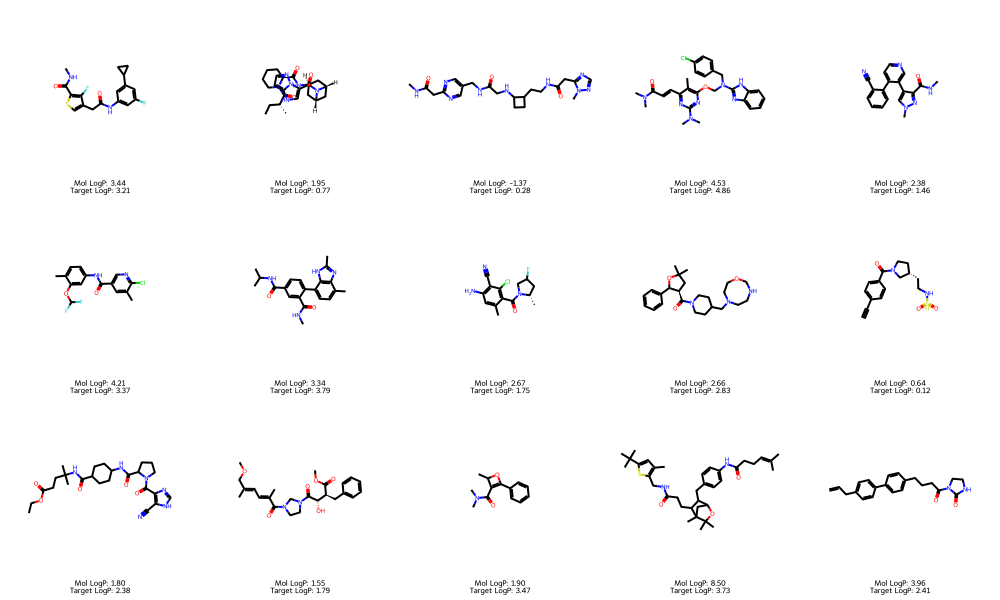

In [57]:
smiles_to_grid_with_logp(valid_smis, generation_logps, invcdf_logp[valid_idxs], 15)

# Conditional Flow

In [7]:
diffusion_model_doc = FLOW_MODELS['logp_flow']
flow_model, train_args, cdfs  = load_flow_model_from_model_doc(diffusion_model_doc)
flow_model = flow_model.to(DEVICE)
flow_dim_per_cond = 32

In [72]:
n_samples = 100
logp_targets, invcdf_logp, embed_logp = get_logp_targets(n_samples,cdf_logp,flow_dim_per_cond)

In [73]:
with torch.no_grad():
    x_0 = torch.randn(n_samples, 512, device=DEVICE)
    x_1_hat = flow_model.decode(x_0,embed_logp)

In [74]:
smis = force_decode_valid_batch_efficient(x_1_hat, coati, tokenizer, 
            max_attempts = 5,
            inv_temp = 1.5, 
            k = 500,
            noise_scale=0., 
            chiral = True,
            silent=False)

29  remaining 
11  remaining 
5  remaining 
3  remaining 
3  remaining 


In [75]:
valid_idxs = [i for i, smi in enumerate(smis) if smi != '']
valid_smis = [smis[i] for i in valid_idxs]
len(valid_idxs)

97

In [76]:
generation_logps = np.asarray([MolLogP(Chem.MolFromSmiles(smi)) for smi in smis if smi != ''])

In [77]:
print(f'Flow logp correlation: {np.corrcoef(generation_logps, invcdf_logp[valid_idxs])[0,1].item()}')

Flow logp correlation: 0.8462740992170139


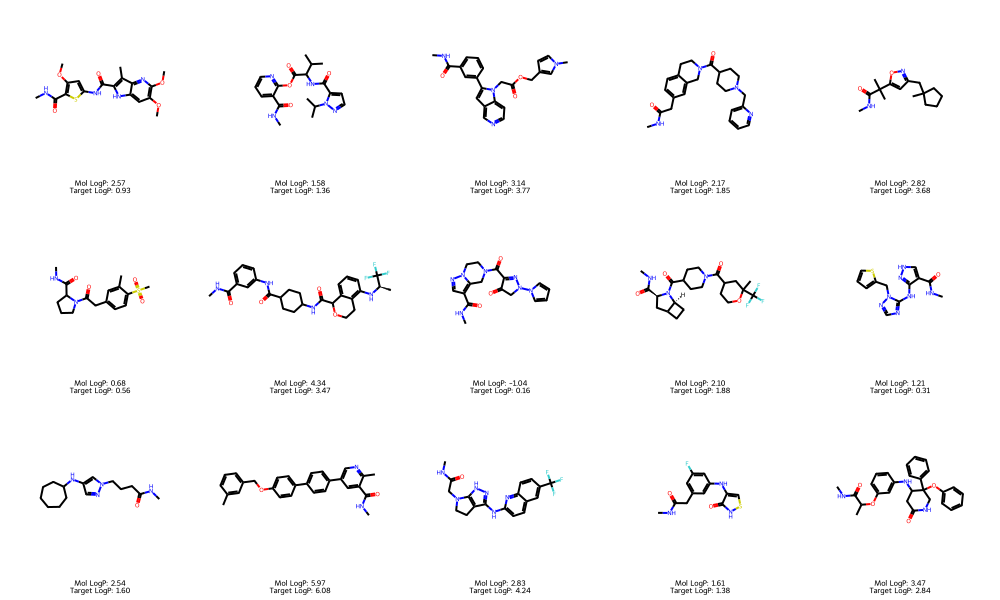

In [78]:
smiles_to_grid_with_logp(valid_smis, generation_logps, invcdf_logp[valid_idxs], 15)

# D-flow

In [8]:
dflow_due = load_inference_due_for_dflow(DFLOW_CLASSIFIER_DOCS['logp'])
bigflow = load_flow_model_from_model_doc(FLOW_MODELS['flow_large'])[0]
# converting the scorenet to this wrapper just makes running dflow easier
bigflow = bigflow.score_net
bigflow = ODEWrapper(bigflow).to(DEVICE)

In [86]:
dflow_due = dflow_due.to(DEVICE)

In [85]:
n_samples = 100
logp_targets, invcdf_logp, embed_logp = get_logp_targets(n_samples,cdf_logp,flow_dim_per_cond)

In [87]:
x_start = torch.randn(n_samples, 512, device=DEVICE)

In [95]:
output = dflow(x_start, target_set=logp_targets, vec_field_net=bigflow, target_net=dflow_due, learning_rate=1.0, decode_steps=100, opt_steps=5, device=DEVICE)

In [101]:
output.shape

torch.Size([100, 100, 512])

In [96]:
# we grab the last output the dflow routine which is the final state of the trajectory
smis = force_decode_valid_batch_efficient(output[-1], coati, tokenizer, 
            max_attempts = 5,
            inv_temp = 1.5, 
            k = 500,
            noise_scale=0., 
            chiral = True,
            silent=False)

37  remaining 
16  remaining 
10  remaining 
6  remaining 
2  remaining 


In [97]:
valid_idxs = [i for i, smi in enumerate(smis) if smi != '']
valid_smis = [smis[i] for i in valid_idxs]
len(valid_idxs)

98

In [98]:
generation_logps = np.asarray([MolLogP(Chem.MolFromSmiles(smi)) for smi in smis if smi != ''])

In [99]:
print(f'D-Flow logp correlation: {np.corrcoef(generation_logps, invcdf_logp[valid_idxs])[0,1].item()}')

D-Flow logp correlation: 0.8136640714483167


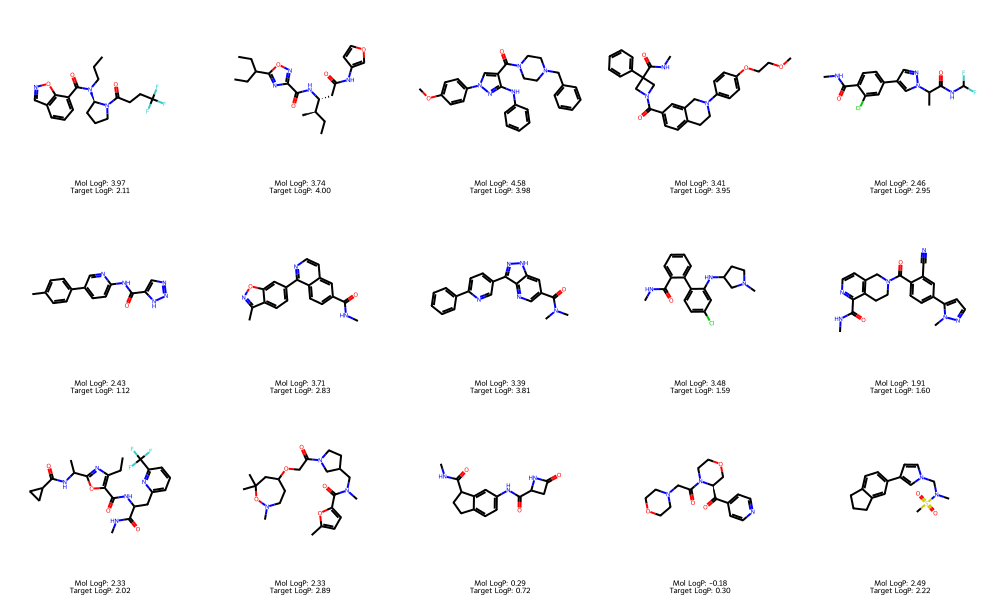

In [100]:
smiles_to_grid_with_logp(valid_smis, generation_logps, invcdf_logp[valid_idxs], 15)